---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
# !cat configs/postprocess.yaml

In [5]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [6]:
%%writefile configs/natl60.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"

# NATL60 GULFSTREAM SIMULATION - REDUCED VERSION
NATL60_GF_1Y1D:
  _target_: "oceanbench._src.data.pipe"
  inp: "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
  fns:
    - {_target_: "xarray.open_dataset", decode_times: False, _partial_: True}
    # VALIDATE COORDINATES
    - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
    - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
    # RESCALE TIME
    - {_target_: "oceanbench._src.geoprocessing.validation.decode_cf_time", units: "seconds since 2012-10-01", _partial_: true}
    # SELECT REGION
    - "${select}"
    - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}

Overwriting configs/natl60.yaml


In [7]:
%%time

# load config
config_dm = OmegaConf.load('./configs/natl60.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D).compute()
ds_natl60

CPU times: user 373 ms, sys: 57.8 ms, total: 431 ms
Wall time: 432 ms


<xarray.Dataset>
Dimensions:  (time: 42, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float64 0.6424 0.6424 0.6486 ... -0.2035 -0.2035

### Prediction Datasets - NADIR

In [8]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet

4DVarNet  DUACS   leaderboard.csv  NerF  results.csv	   results_nerf.csv
BFNQG	  DYMOST  MIOST		   OI	 results_demo.csv
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [9]:
# load config
results_config = OmegaConf.load(f'./configs/results.yaml')

# instantiate
ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
ds_bfnqg = hydra.utils.instantiate(results_config.BFNQG_NADIR.data).compute()
ds_4dvarnet = hydra.utils.instantiate(results_config.FourDVARNET_NADIR.data).compute()
# ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
# ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
# ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()

## Post Processing Chain

* Coordinate Change
* PSD Metrics

In [10]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid
from oceanbench._src.geoprocessing.interpolate import fillnan_gauss_seidel
from oceanbench._src.geoprocessing import geostrophic as geocalc
from oceanbench._src.geoprocessing.spatial import latlon_deg2m
from oceanbench._src.geoprocessing.temporal import time_rescale
from metpy.units import units
import pint_xarray

def postprocess_fn(ds, ds_reference):
    
    # resample
    ds = ds.resample(time="1D").mean()

    # regrid
    ds = grid_to_regular_grid(
        src_grid_ds=ds.pint.dequantify(),
        tgt_grid_ds=ds_reference.pint.dequantify(), keep_attrs=False
    )
    
    # fill nans
    ds = fillnan_gauss_seidel(ds, variable="ssh")
    
    # coordinate change
    ds = latlon_deg2m(ds, mean=True)
    ds = time_rescale(ds, t0="2012-10-22", freq_dt=1, freq_unit="D")
    
    
    return ds

In [11]:
ds_natl60_ = ds_natl60.pipe(lambda x: postprocess_fn(x, ds_natl60))
ds_duacs = ds_duacs.pipe(lambda x: postprocess_fn(x, ds_natl60))
ds_miost = ds_miost.pipe(lambda x: postprocess_fn(x, ds_natl60))
ds_bfnqg = ds_bfnqg.pipe(lambda x: postprocess_fn(x, ds_natl60))
ds_4dvarnet = ds_4dvarnet.pipe(lambda x: postprocess_fn(x, ds_natl60))

## Power Spectrum (Spacetime)

In [12]:
%%writefile configs/metrics.yaml

fill_nans:
    _target_: "oceanbench._src.geoprocessing.interpolate.fillnan_gauss_seidel"
    _partial_: True
    variable: "ssh"
    
spatial_rescale:
    _target_: "oceanbench._src.geoprocessing.spatial.latlon_deg2m"
    _partial_: True
    mean: True

temporal_rescale:
    _target_: "oceanbench._src.geoprocessing.temporal.time_rescale"
    _partial_: True
    t0: "2012-10-22"
    freq_dt: 1
    freq_unit: "D"
    
psd_isotropic:
    _target_: "oceanbench._src.metrics.power_spectrum.psd_isotropic"
    _partial_: True
    variable: "ssh"
    dims: ["lon", "lat"]
    detrend: "constant"
    window: "tukey"
    nfactor: 2
    window_correction: True
    true_amplitude: True
    truncate: True
    
psd_isotropic_score:
    _target_: "oceanbench._src.metrics.power_spectrum.psd_isotropic_score"
    variable: "ssh"
    psd_dims: ["lon", "lat"]
    avg_dims: ["time"]
    detrend: "constant"
    window: "tukey"
    nfactor: 2
    window_correction: True
    true_amplitude: True
    truncate: True
    
psd_spacetime_score:
    _target_: "oceanbench._src.metrics.power_spectrum.psd_spacetime_score"
    variable: "ssh"
    psd_dims: ["time", "lon"]
    avg_dims: ["lat"]
    detrend: "constant"
    window: "tukey"
    nfactor: 2
    window_correction: True
    true_amplitude: True
    truncate: True
    
psd_spacetime:
    _target_: "oceanbench._src.metrics.power_spectrum.psd_spacetime"
    _partial_: True
    variable: "ssh"
    dims: ["time", "lon"]
    detrend: "constant"
    window: "tukey"
    nfactor: 2
    window_correction: True
    true_amplitude: True
    truncate: True
    
psd_isotropic_avg:
    _target_: "oceanbench._src.preprocessing.mean.xr_cond_average"
    _partial_: True
    dims: ["time"]
    drop: True
    
psd_spacetime_avg:
    _target_: "oceanbench._src.preprocessing.mean.xr_cond_average"
    _partial_: True
    dims: ["lat"]
    drop: True
    
    
psd_preprocess_chain:
    _target_: "oceanbench._src.data.pipe"
    _partial_: true
    fns:
        - "${fill_nans}" # FILL NANs
        - "${spatial_rescale}" # RESCALE LATLON DEGREEs -> METERS
        - "${temporal_rescale}" # RESCALE TIME -> DAYS


psd_isotropic_chain:
    _target_: "oceanbench._src.data.pipe"
    _partial_: true
    fns:
        - "${psd_isotropic}" # ISOTROPIC POWER SPECTRUM
        - "${psd_isotropic_avg}" # AVERAGE TIME DIMENSIONS
        
psd_spacetime_chain:
    _target_: "oceanbench._src.data.pipe"
    _partial_: true
    fns:
        - "${psd_spacetime}" # ISOTROPIC POWER SPECTRUM
        - "${psd_spacetime_avg}" # AVERAGE LATITUDE DIMENSIONS

Overwriting configs/metrics.yaml


In [13]:
# load config
metrics_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_chain)(ds_natl60_)
ds_duacs_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_chain)(ds_duacs)
ds_miost_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_chain)(ds_miost)
ds_bfnqg_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_chain)(ds_bfnqg)
ds_4dvarnet_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_chain)(ds_4dvarnet)


In [14]:
from utils import PlotPSDSpaceTime, PlotPSDSpaceTimeScore

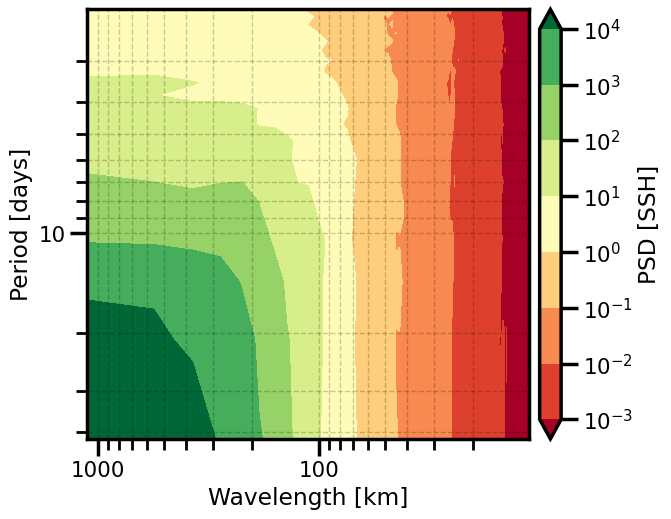

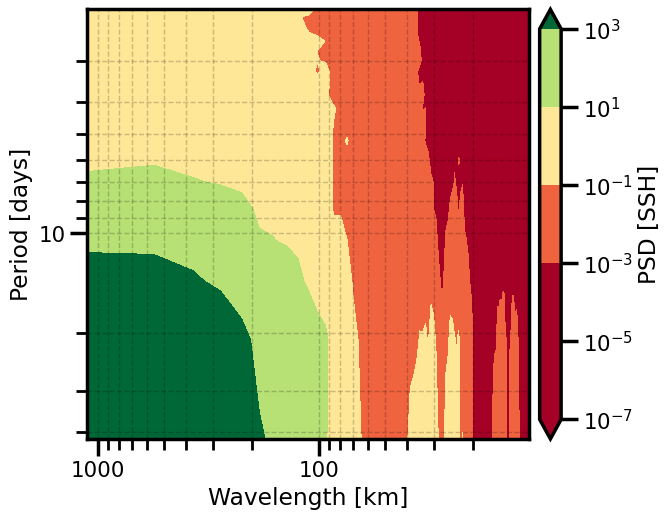

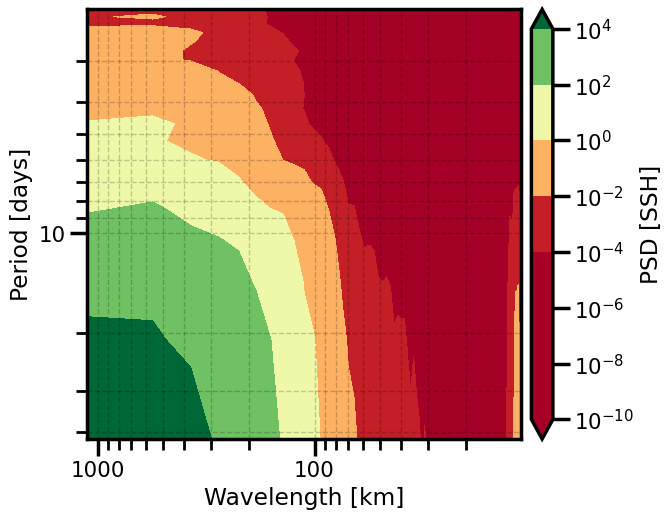

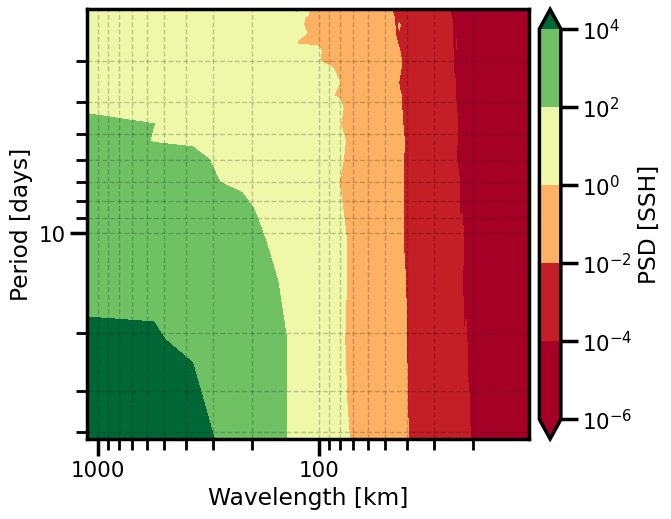

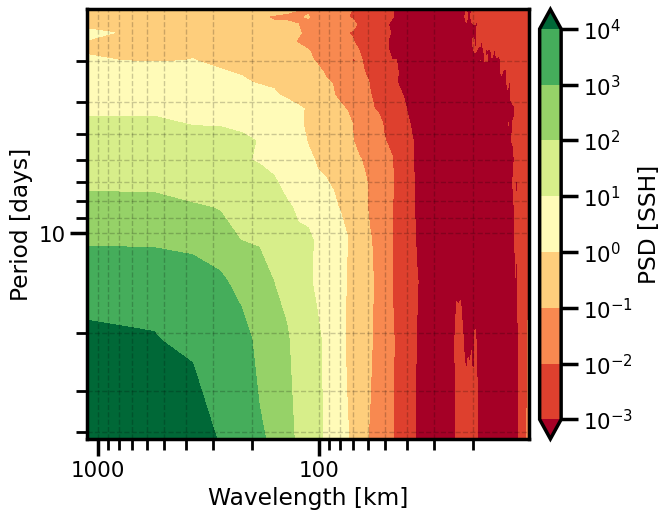

In [15]:
# NATL60
fig, ax = plt.subplots( figsize=(7, 5.5))
vmin = ds_natl60_psd.ssh.min()
vmax = ds_natl60_psd.ssh.max()
psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_natl60_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH",
    vmin=vmin, vmax=vmax
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_nemo_nadir4_ssh.png")
plt.show()

# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_duacs_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH",
    vmin=vmin, vmax=vmax
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_duacs_nadir4_ssh.png")
plt.show()

# MIOST
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_miost_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH",
    vmin=vmin, vmax=vmax
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_miost_nadir4_ssh.png")
plt.show()

# BFN-QG
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_bfnqg_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH",
    vmin=vmin, vmax=vmax
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_bfnqg_nadir4_ssh.png")
plt.show()


# 4DVarNet
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_4dvarnet_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH",
    vmin=vmin, vmax=vmax
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_4dvarnet_nadir4_ssh.png")
plt.show()

## Power Spectrum Score (Spacetime)

In [18]:
# load config
metrics_config = OmegaConf.load('./configs/metrics.yaml')

ds_duacs_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_score)(ds_duacs, ds_natl60_)
ds_miost_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_score)(ds_miost, ds_natl60_)
ds_bfnqg_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_score)(ds_bfnqg, ds_natl60_)
ds_4dvarnet_psd = hydra.utils.instantiate(metrics_config.psd_spacetime_score)(ds_4dvarnet, ds_natl60_)


In [20]:
from utils import PlotPSDSpaceTime, PlotPSDSpaceTimeScore

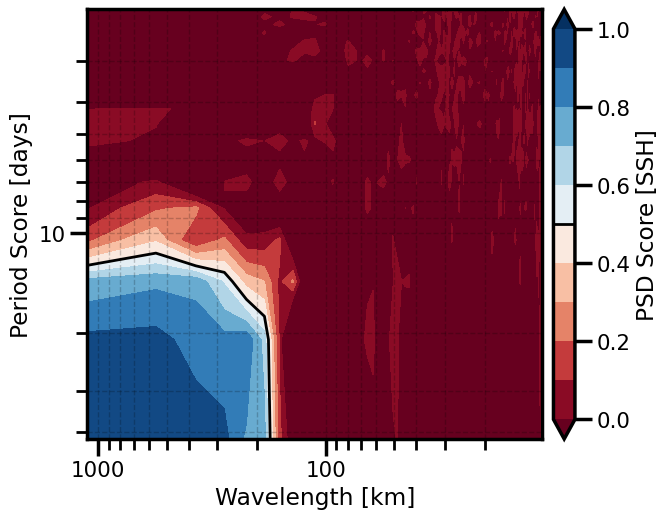

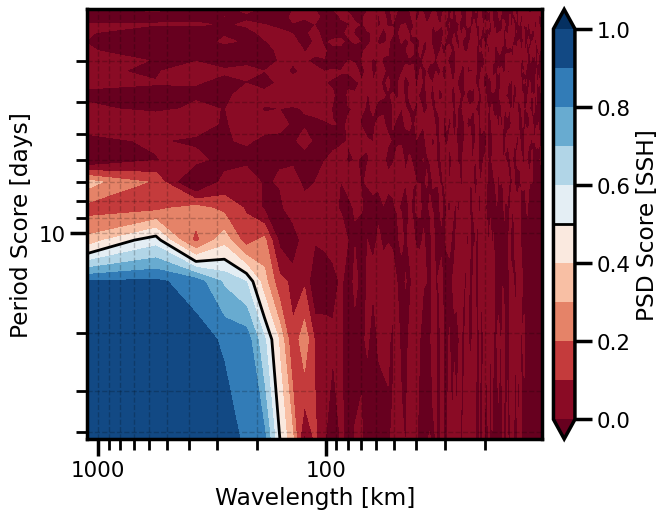

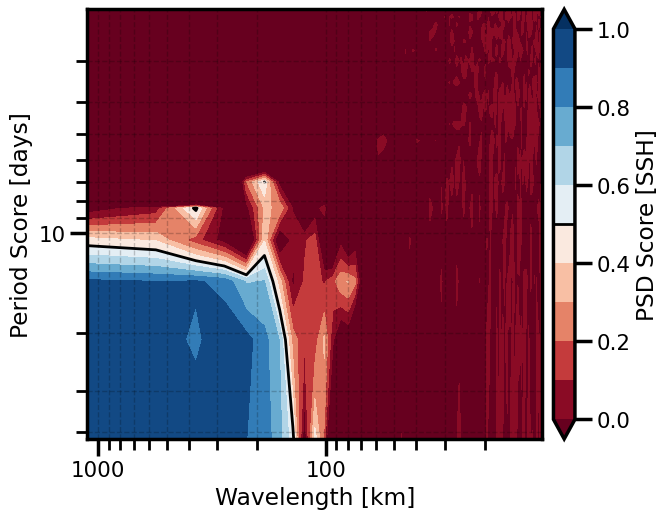

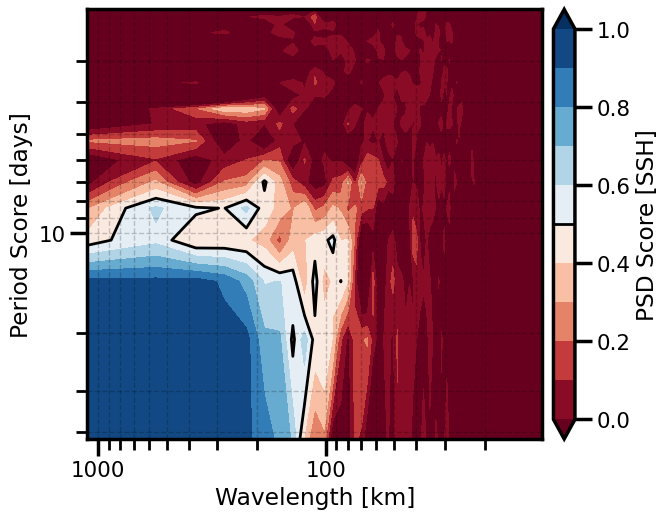

In [24]:
# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_duacs_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_score_duacs_nadir4_ssh.png")
plt.show()

# MIOST
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_miost_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_score_miost_nadir4_ssh.png")
plt.show()

# BFN-QG
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_bfnqg_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_score_bfnqg_nadir4_ssh.png")
plt.show()

# 4DVarNet
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_4dvarnet_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/psd_spacetime/dc20a_psd_spacetime_score_4dvarnet_nadir4_ssh.png")
plt.show()

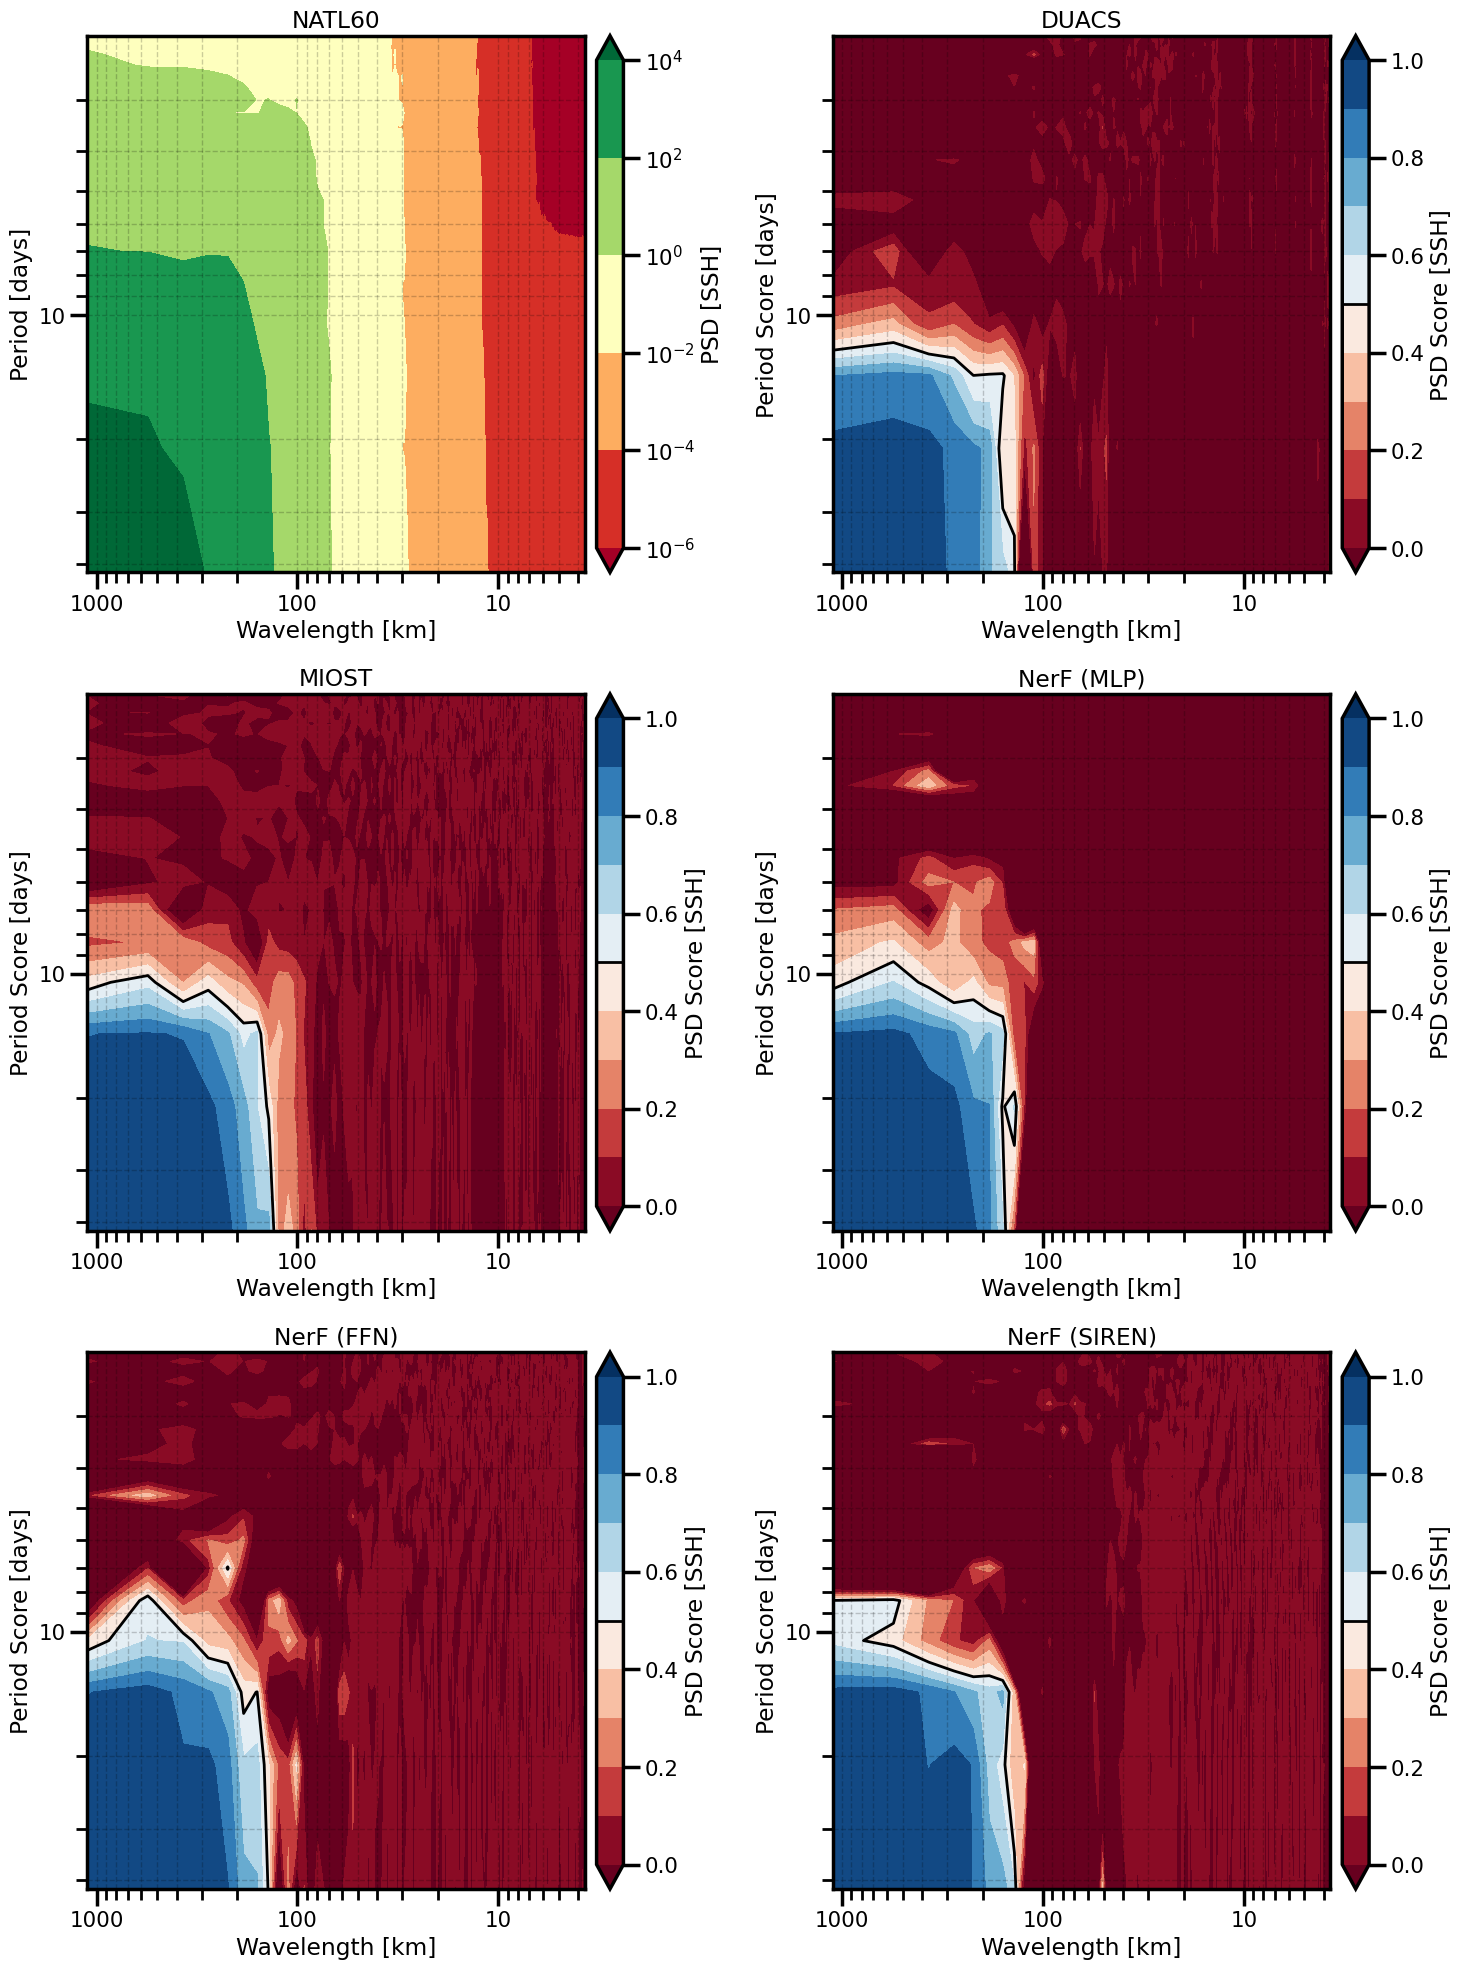

In [51]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,20))

# NATL60
psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax[0,0])
psd_st_plot.plot_wavelength(
    ds_natl60_psd.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
ax[0,0].set(title="NATL60")

# DUACS
psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax[0,1])
psd_st_plot.plot_wavelength(
    ds_psd_duacs_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
ax[0,1].set(title="DUACS")

# MIOST
psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax[1,0])
psd_st_plot.plot_wavelength(
    ds_psd_miost_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
ax[1,0].set(title="MIOST")

# NERF - MLP
psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax[1,1])
psd_st_plot.plot_wavelength(
    ds_psd_nerf_mlp_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
ax[1,1].set(title="NerF (MLP)")

# NERF - FFN
psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax[2,0])
psd_st_plot.plot_wavelength(
    ds_psd_nerf_ffn_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
ax[2,0].set(title="NerF (FFN)")

# NERF - SIREN
psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax[2,1])
psd_st_plot.plot_wavelength(
    ds_psd_nerf_siren_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
ax[2,1].set(title="NerF (SIREN)")

plt.tight_layout()
plt.gcf().savefig(f"./figures/dc20a/psd_score/spacetime/dc20a_psd_spacetime_score_{experiment}.png")
plt.show()

### DUACS

In [52]:
# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_psd_duacs_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures//dc20a/psd_score/spacetime/dc20a_psd_spacetime_score_ssh_duacs_{experiment}.png")
plt.close()

### MIOST

In [53]:
# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_psd_miost_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/dc20a/psd_score/spacetime/dc20a_psd_spacetime_score_ssh_miost_{experiment}.png")
plt.close()

### NERF (MLP)

In [54]:
# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_psd_nerf_mlp_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/dc20a/psd_score/spacetime/dc20a_psd_spacetime_score_ssh_nerf_mlp_{experiment}.png")
plt.close()

### NERF (FFN)

In [55]:
# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_psd_nerf_ffn_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/dc20a/psd_score/spacetime/dc20a_psd_spacetime_score_ssh_nerf_ffn_{experiment}.png")
plt.close()

### NERF (SIREN)

In [56]:
# DUACS
fig, ax = plt.subplots( figsize=(7, 5.5))

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig(ax=ax)
psd_st_plot.plot_wavelength(
    ds_psd_nerf_siren_score.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.tight_layout()
plt.gcf().savefig(f"./figures/dc20a/psd_score/spacetime/dc20a_psd_spacetime_score_ssh_nerf_siren_{experiment}.png")
plt.close()